# Port of emcee's autocorrelation time tutorial to arviz
The original post by Dan Foreman-Mackey can be found at https://emcee.readthedocs.io/en/latest/tutorials/autocorr/#autocorr. I recommend to at least skim Dan's post before reading this one.

This notebook adds to emcee's autocorrelation tutorial an extra way to perform the calculations. emcee implements the calcualtion of the autocorrelation time using [Alan Sokal's notes](https://pdfs.semanticscholar.org/0bfe/9e3db30605fe2d4d26e1a288a5e2997e7225.pdf). [ArviZ](https://arviz-devs.github.io/arviz/) implements Gelman-Rubin $\hat{R}$ and effective sample size as described in:
  
* Aki Vehtari, Andrew Gelman, Daniel Simpson, Bob Carpenter, Paul-Christian Bürkner (2019): Rank-normalization, folding, and localization: An improved R-hat for assessing convergence of MCMC. [arXiv preprint arXiv:1903.08008](https://arxiv.org/abs/1903.08008). 

Both approaches to estimate the autocorrelation time are compared to see whether or not they both yield the proper result for emcee, whose chains/walkers are not independent like in HMC.

The original post starts with a toy problem to validate the algorithm. This toy problem consists in generating some data whose autocorrelation time is already known to compare the autocorrelation value returned by emcee and ArviZ with the true autocorrelation time.

## Toy problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import arviz as az
import emcee
import celerite
from celerite import terms

np.random.seed(1234)

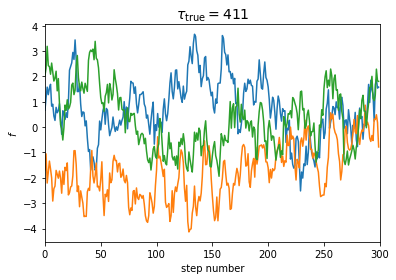

In [2]:
# Build the celerite model:
kernel = terms.RealTerm(log_a=0.0, log_c=-6.0)
kernel += terms.RealTerm(log_a=0.0, log_c=-2.0)

# The true autocorrelation time can be calculated analytically:
true_tau = sum(2*np.exp(t.log_a-t.log_c) for t in kernel.terms)
true_tau /= sum(np.exp(t.log_a) for t in kernel.terms)
true_tau

# Simulate a set of chains:
gp = celerite.GP(kernel)
t = np.arange(2000000)
gp.compute(t)
y = gp.sample(size=32)

# Let's plot a little segment with a few samples:
plt.plot(y[:3, :300].T)
plt.xlim(0, 300)
plt.xlabel("step number")
plt.ylabel("$f$")
plt.title("$\\tau_\mathrm{{true}} = {0:.0f}$".format(true_tau), fontsize=14);

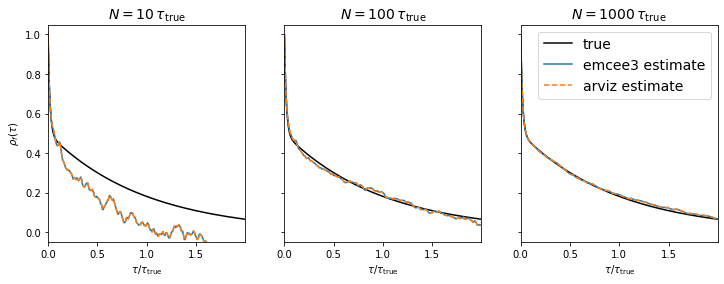

In [3]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2*n)
    acf = np.fft.ifft(f * np.conjugate(f))[:len(x)].real
    acf /= 4*n

    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf

# Make plots of ACF estimate for a few different chain lengths
window = int(2*true_tau)
tau = np.arange(window+1)
f0 = kernel.get_value(tau) / kernel.get_value(0.0)

# Loop over chain lengths:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
for n, ax in zip([10, 100, 1000], axes):
    nn = int(true_tau * n)
    ax.plot(tau / true_tau, f0, "k", label="true")
    ax.plot(tau / true_tau, autocorr_func_1d(y[0, :nn])[:window+1], label="emcee3 estimate")
    ax.plot(tau / true_tau, az.autocorr(y[0,:nn])[:window+1], label="arviz estimate",ls='--')
    ax.set_title(r"$N = {0}\,\tau_\mathrm{{true}}$".format(n), fontsize=14)
    ax.set_xlabel(r"$\tau / \tau_\mathrm{true}$")

axes[0].set_ylabel(r"$\rho_f(\tau)$")
axes[-1].set_xlim(0, window / true_tau)
axes[-1].set_ylim(-0.05, 1.05)
axes[-1].legend(fontsize=14);

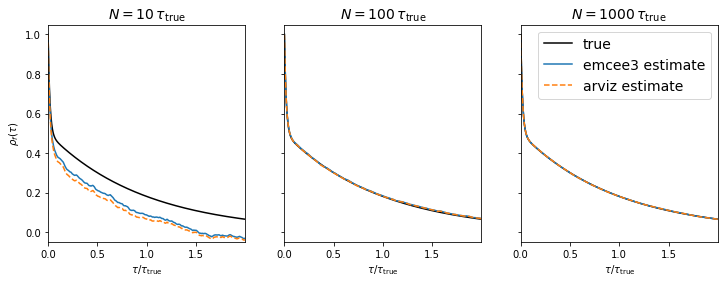

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
for n, ax in zip([10, 100, 1000], axes):
    nn = int(true_tau * n)
    ax.plot(tau / true_tau, f0, "k", label="true")
    f = np.mean([autocorr_func_1d(y[i, :nn], norm=False)[:window+1]
                 for i in range(len(y))], axis=0)
    f /= f[0]
    ax.plot(tau / true_tau, f, label="emcee3 estimate")
    f_az = az.autocorr(y[:,:nn],axis=1)[:,:window+1]
    f_az = f_az.mean(axis=0)
    ax.plot(tau / true_tau, f_az/f_az[0], label="arviz estimate",ls='--')
    ax.set_title(r"$N = {0}\,\tau_\mathrm{{true}}$".format(n), fontsize=14)
    ax.set_xlabel(r"$\tau / \tau_\mathrm{true}$")

axes[0].set_ylabel(r"$\rho_f(\tau)$")
axes[-1].set_xlim(0, window / true_tau)
axes[-1].set_ylim(-0.05, 1.05)
axes[-1].legend(fontsize=14);

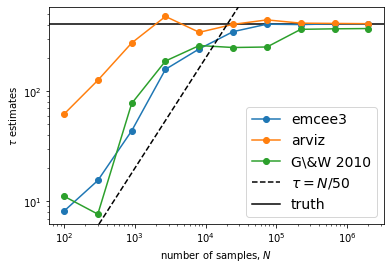

In [5]:
# Automated windowing procedure following Sokal (1989)
def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1

# Following the suggestion from Goodman & Weare (2010)
def autocorr_gw2010(y, c=5.0):
    f = autocorr_func_1d(np.mean(y, axis=0))
    taus = 2.0*np.cumsum(f)-1.0
    window = auto_window(taus, c)
    return taus[window]

def autocorr_new(y, c=5.0):
    f = np.zeros(y.shape[1])
    for yy in y:
        f += autocorr_func_1d(yy)
    f /= len(y)
    taus = 2.0*np.cumsum(f)-1.0
    window = auto_window(taus, c)
    return taus[window]

# Compute the estimators for a few different chain lengths
N = np.exp(np.linspace(np.log(100), np.log(y.shape[1]), 10)).astype(int)
gw2010 = np.empty(len(N))
new = np.empty(len(N))
az_tau = np.empty(len(N))
for i, n in enumerate(N):
    gw2010[i] = autocorr_gw2010(y[:, :n])
    new[i] = autocorr_new(y[:, :n])
    az_tau[i] = 1/az.ess(y[:, :n], relative=True, method="mean")

# Plot the comparisons
plt.loglog(N, new, "o-", label="emcee3")
plt.loglog(N, az_tau, "o-", label="arviz")
plt.loglog(N, gw2010, "o-", label="G\&W 2010")
ylim = plt.gca().get_ylim()
plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
plt.axhline(true_tau, color="k", label="truth", zorder=-100)
plt.ylim(ylim)
plt.xlabel("number of samples, $N$")
plt.ylabel(r"$\tau$ estimates")
plt.legend(fontsize=14);

This figure add ArviZ to the comparison between emcee3 autocorrelation time calculation and the original algorithm proposed in:

* Goodman, J., & Weare, J. (2010). Ensemble samplers with affine invariance. Communications in applied mathematics and computational science, 5(1), 65-80.

to estimate the autocorrelation time of Affine Invariant MCMC Ensemble Samplers.

## A more realistic example
A second example is also tested to show that the autocorrelation time converges to a given value as the number of samples grow independently of the method used.

In [6]:
def log_prob(p):
    return np.logaddexp(-0.5*np.sum(p**2), -0.5*np.sum((p-4.0)**2))

sampler = emcee.EnsembleSampler(32, 3, log_prob)
sampler.run_mcmc(
    np.concatenate((np.random.randn(16, 3), 4.0+np.random.randn(16, 3)), axis=0),
    500000, 
    progress=True
);

100%|██████████| 500000/500000 [07:39<00:00, 1089.08it/s]


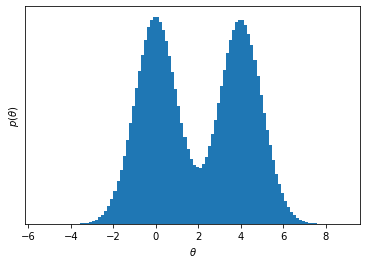

In [7]:
chain = sampler.get_chain()[:, :, 0].T

plt.hist(chain.flatten(), 100)
plt.gca().set_yticks([])
plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta)$");

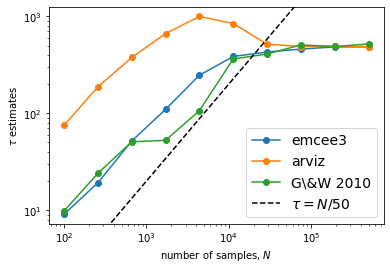

In [8]:
# Compute the estimators for a few different chain lengths
N = np.exp(np.linspace(np.log(100), np.log(chain.shape[1]), 10)).astype(int)
gw2010 = np.empty(len(N))
new = np.empty(len(N))
az_tau = np.empty(len(N))
for i, n in enumerate(N):
    gw2010[i] = autocorr_gw2010(chain[:, :n])
    new[i] = autocorr_new(chain[:, :n])
    az_tau[i] = 1/az.ess(chain[:, :n], relative=True, method="mean")

# Plot the comparisons
plt.loglog(N, new, "o-", label="emcee3")
plt.loglog(N, az_tau, "o-", label="arviz")
plt.loglog(N, gw2010, "o-", label="G\&W 2010")
ylim = plt.gca().get_ylim()
plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
plt.ylim(ylim)
plt.xlabel("number of samples, $N$")
plt.ylabel(r"$\tau$ estimates")
plt.legend(fontsize=14);

This figure shows the comparison between the 3 autocorrelation time computation algorithms. It can be seen that indeed all 3 methods converge to the same value for a large number of samples. However, when there are fewer samples, there are important differences between ArviZ and emcee results. ArviZ tends to return a larger (and closer to the asymptote) value. It also overestimates the autocorrelation time for medium sample sizes, however, an overestimation like this would only make the user increase the number of samples, which is no big problem in general. If ArviZ instead tended to underestimate the autocorrelation time, some incorrect or unconverged result could be interpreted as correct. Overall, it looks like, again, ArviZ's implementation can be used to estimate the proper autocorrelation time.

Note: I am using `method="mean"` in ArviZ effective sample size because our goal is to estimate the effective sample size (and then from it the autocorrelation time), however, to assess MCMC convergence, methods `"bulk"` (default method for `az.ess`) and `"tail"` are recommended.

## What about shorter chains?

In [9]:
from scipy.optimize import minimize

def autocorr_ml(y, thin=1, c=5.0, kind='emcee3'):
    # Compute the initial estimate of tau using the standard method
    if kind == 'arviz':
        init = 1/az.ess(y, relative=True, method="mean")
    else:  
        init = autocorr_new(y, c=c)
    z = y[:, ::thin]
    N = z.shape[1]

    # Build the GP model
    tau = max(1.0, init/thin)
    kernel = terms.RealTerm(np.log(0.9*np.var(z)), -np.log(tau),
                        bounds=[(-5.0, 5.0), (-np.log(N), 0.0)])
    kernel += terms.RealTerm(np.log(0.1*np.var(z)), -np.log(0.5*tau),
                             bounds=[(-5.0, 5.0), (-np.log(N), 0.0)])
    gp = celerite.GP(kernel, mean=np.mean(z))
    gp.compute(np.arange(z.shape[1]))

    # Define the objective
    def nll(p):
        # Update the GP model
        gp.set_parameter_vector(p)

        # Loop over the chains and compute likelihoods
        v, g = zip(*(
            gp.grad_log_likelihood(z0, quiet=True)
            for z0 in z
        ))

        # Combine the datasets
        return -np.sum(v), -np.sum(g, axis=0)

    # Optimize the model
    p0 = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()
    soln = minimize(nll, p0, jac=True, bounds=bounds)
    gp.set_parameter_vector(soln.x)

    # Compute the maximum likelihood tau
    a, c = kernel.coefficients[:2]
    tau = thin * 2*np.sum(a / c) / np.sum(a)
    return tau

# Calculate the estimate for a set of different chain lengths
ml = np.empty(len(N))
ml[:] = np.nan
ml_az = np.empty(len(N))
ml_az[:] = np.nan
for j, n in enumerate(N[1:8]):
    i = j+1
    thin = max(1, int(0.05*new[i]))
    ml[i] = autocorr_ml(chain[:, :n], thin=thin)
    ml_az[i] = autocorr_ml(chain[:, :n], kind='arviz')

/home/oriol/venvs/arviz-dev/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/home/oriol/venvs/arviz-dev/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/home/oriol/venvs/arviz-dev/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. 

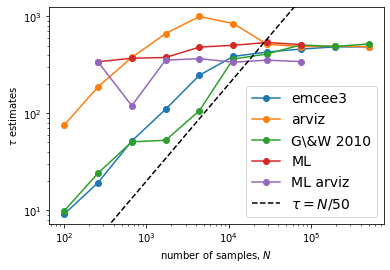

In [10]:
# Plot the comparisons
plt.loglog(N, new, "o-", label="emcee3")
plt.loglog(N, az_tau, "o-", label="arviz")
plt.loglog(N, gw2010, "o-", label="G\&W 2010")
plt.loglog(N, ml, "o-", label="ML")
plt.loglog(N, ml_az, "o-", label="ML arviz")
ylim = plt.gca().get_ylim()
plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
plt.ylim(ylim)
plt.xlabel("number of samples, $N$")
plt.ylabel(r"$\tau$ estimates")
plt.legend(fontsize=14);

## Back to toy model

In [11]:
# Compute the estimators for a few different chain lengths
N = np.exp(np.linspace(np.log(100), np.log(y.shape[1]), 10)).astype(int)
gw2010 = np.empty(len(N))
new = np.empty(len(N))
az_tau = np.empty(len(N))
for i, n in enumerate(N):
    gw2010[i] = autocorr_gw2010(y[:, :n])
    new[i] = autocorr_new(y[:, :n])
    az_tau[i] = 1/az.ess(y[:, :n], relative=True, method="mean")
    
# Calculate the estimate for a set of different chain lengths
ml = np.empty(len(N))
ml[:] = np.nan
ml_az = np.empty(len(N))
ml_az[:] = np.nan
for j, n in enumerate(N[1:8]):
    i = j+1
    thin = max(1, int(0.05*new[i]))
    ml[i] = autocorr_ml(y[:, :n], thin=thin)
    ml_az[i] = autocorr_ml(y[:, :n], kind='arviz')

/home/oriol/venvs/arviz-dev/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/home/oriol/venvs/arviz-dev/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/home/oriol/venvs/arviz-dev/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. 

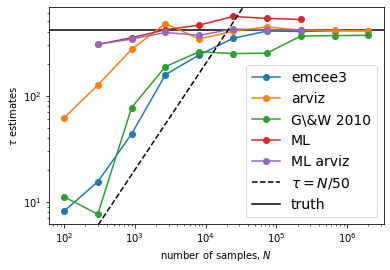

In [12]:
# Plot the comparisons
plt.loglog(N, new, "o-", label="emcee3")
plt.loglog(N, az_tau, "o-", label="arviz")
plt.loglog(N, gw2010, "o-", label="G\&W 2010")
plt.loglog(N, ml, "o-", label="ML")
plt.loglog(N, ml_az, "o-", label="ML arviz")
ylim = plt.gca().get_ylim()
plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
plt.axhline(true_tau, color="k", label="truth", zorder=-100)
plt.ylim(ylim)
plt.xlabel("number of samples, $N$")
plt.ylabel(r"$\tau$ estimates")
plt.legend(fontsize=14);

## A 2nd realistic example

In [13]:
J = 8
y_obs = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

def log_prior_8school(theta, J):
    mu, tau, eta = theta[0], theta[1], theta[2:]
    # Half-cauchy prior, hwhm=25
    if tau < 0:
        return -np.inf
    prior_tau = -np.log(tau ** 2 + 25 ** 2)
    prior_mu = -(mu / 10) ** 2  # normal prior, loc=0, scale=10
    prior_eta = -np.sum(eta ** 2)  # normal prior, loc=0, scale=1
    return prior_mu + prior_tau + prior_eta

def log_likelihood_8school(theta, y, sigma):
    mu, tau, eta = theta[0], theta[1], theta[2:]
    return -((mu + tau * eta - y) / sigma) ** 2

def lnprob_8school(theta, J, y, sigma):
    prior = log_prior_8school(theta, J)
    like_vect = log_likelihood_8school(theta, y, sigma)
    like = np.sum(like_vect)
    return like + prior

nwalkers, draws = 60, 60000
ndim = J + 2
pos = np.random.normal(size=(nwalkers, ndim))
pos[:, 1] = np.absolute(pos[:, 1])

sampler = emcee.EnsembleSampler(
    nwalkers,
    ndim,
    lnprob_8school,
    args=(J, y_obs, sigma),
)
sampler.run_mcmc(pos, draws, progress=True);

100%|██████████| 60000/60000 [01:51<00:00, 538.12it/s]


In [14]:
idata = az.from_emcee(sampler)
burnin = 1000
idata.sel(draw=slice(burnin,None))
data_8school = idata.posterior.to_array().values.swapaxes(0,2).swapaxes(0,1)

In [15]:
# Compute the estimators for a few different chain lengths
N = np.exp(np.linspace(np.log(100), np.log(data_8school.shape[1]), 10)).astype(int)
gw2010 = np.empty((len(N),ndim))
new = np.empty((len(N),ndim))
az_tau = np.empty((len(N),ndim))

for d in range(ndim):
    chain = data_8school[:,:,d]
    for i, n in enumerate(N):
        gw2010[i,d] = autocorr_gw2010(chain[:, :n])
        new[i,d] = autocorr_new(chain[:, :n])
        az_tau[i,d] = 1/az.ess(chain[:, :n], relative=True, method="mean")

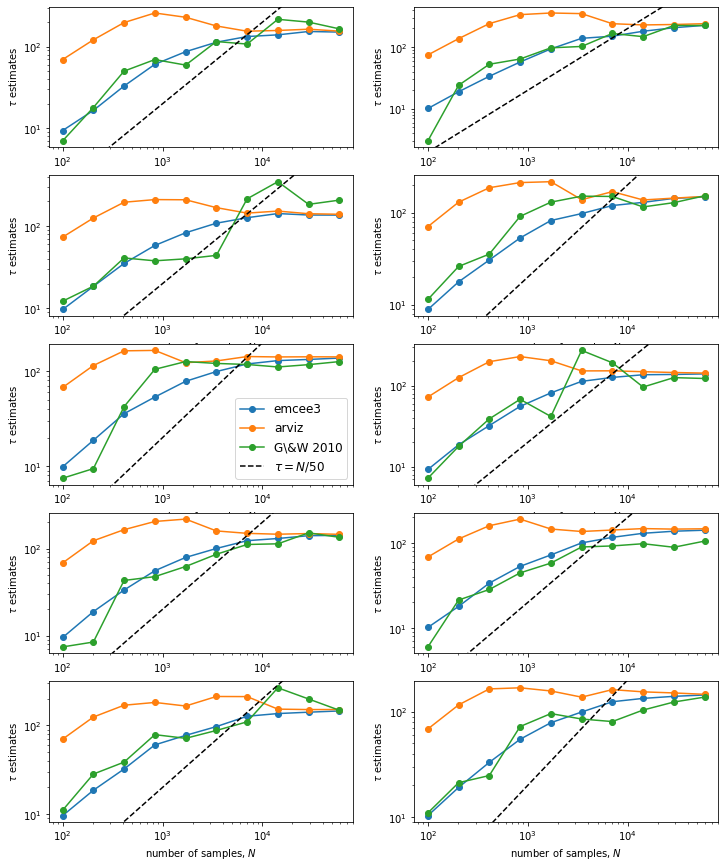

In [16]:
fig, axes = plt.subplots(5,2,figsize=(12,15))
axes = axes.flatten()
for d in range(ndim):
    # Plot the comparisons
    ax = axes[d]
    ax.loglog(N, new[:,d], "o-", label="emcee3")
    ax.loglog(N, az_tau[:,d], "o-", label="arviz")
    ax.loglog(N, gw2010[:,d], "o-", label="G\&W 2010")
    ylim = ax.get_ylim()
    ax.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
    ax.set_ylim(ylim)
    ax.set_xlabel("number of samples, $N$")
    ax.set_ylabel(r"$\tau$ estimates")
axes[4].legend(fontsize=12);

To sum up, ArviZ results converge to the same value as emcee estimates, and when they don't, it is always for $\tau > N/50$. Moreover, for $\tau > N/50$, ArviZ result tends to be more restrictive, thus, it enforces convergence criterion $\tau < N/50$ in a little more strict manner than emcee.